# Architecture

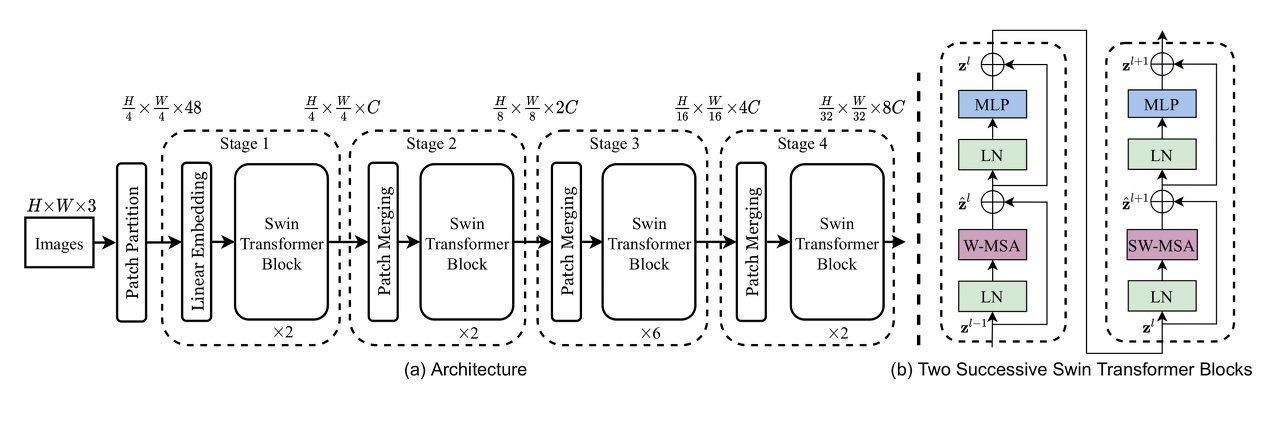

# Relative Position Bias
윈도우 내부에 있는 패치들끼리의 상대적인 좌표를 계산

In [ ]:
def get_relative_position_index(win_h, win_w):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid([torch.arange(win_h), torch.arange(win_w)]))  # 2, Wh, Ww
    # meshgrid 함수와 stack 함수로 각 패치의 윈도우 내에서 x,y좌표를 각각 나타낸다
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    #뺄셈을 통해 각 패치간의 상대적인 x,y 좌표를 계산
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # 상대적인 좌표의 최소 0이 되도록 병경
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1 #x(세로)축의 상대적인 좌표를 해당 값으로 스케일림
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww x,y 상대적인 좌표를 더해준 후에 출

# Patch Partition

In [ ]:
class PatchPartition(nn.Module):
    def __init__(self,
                 patch_size: int = 4,
                 ):
        """
        this
        patch partition + Linear Embedding
        :param patch_size:
        """
        super().__init__()
        self.proj = nn.Conv2d(3, 96, kernel_size=patch_size, stride=patch_size)
        #Patch_size의 필터를 가지는 Conv로 Patch Partition 과 Linear embedding을 한번에 구현
        self.norm = nn.LayerNorm(96)

    def forward(self, x):
        x = self.proj(x)                  # [Batch, 96, 56, 56]
        x = x.flatten(2).transpose(1, 2)
        # BCHW -> (B, 56*56, 96) index 1차원은 트랜스포머에서 시퀀스의 길이
        # BLC
        x = self.norm(x)
        return x

# Swin Transformer Block

relative positional encoding은 제외한 형태


# W-MSA

In [ ]:
class W_MSA(nn.Module):
    def __init__(self,
                 dim, num_heads, head_dim=None, window_size=7,
                 qkv_bias=True, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size #1개의 윈도우를 구성하는  H,W
        self.num_heads = num_heads
        head_dim = head_dim or dim // num_heads #1개의 헤드에 입력되는 q,k,v 차원
        attn_dim = head_dim * num_heads
        self.scale = head_dim ** -0.5

        # define a parameter table of relative position bias, shape: 2*Wh-1 * 2*Ww-1, nH
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * 7 - 1) * (2 * 7 - 1), num_heads))
        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(7, 7))
        trunc_normal_(self.relative_position_bias_table, std=.02)

        self.qkv = nn.Linear(dim, attn_dim * 3, bias=qkv_bias) #입력을 q,k,v 로 나누어줌.
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(attn_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self) -> torch.Tensor:
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(49, 49, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x):
        # setting
        B, L, C = x.shape # Patch Partition의 출력을 입력으로 받음
        ws = self.window_size
        w = h = int(math.sqrt(L))
        h_ = int(h // ws)
        w_ = int(w // ws) # h_ * w_ = 윈도우의 갯수

        # [B, 3136, C]
        # ----------- efficient batch computation for shifted configuration -----------
        x = x.view(B, h, w, C)                        # [B, H, W, C]
        x = x.view(B, h_, ws, w_, ws, C)              # [0, 1, 2, 3, 4, 5 ] -> [0, 1, 3, 2, 4, 5 ] - idx
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()  # [B, 8, 7, 8, 7, 96] -> [B, 8, 8, 7, 7, 96]
        x = x.view(B * h_ * w_, ws * ws, C)           # [B' = B x 8 x 8],   -> [B'         49, 96]
        # 어텐션 연산을 위해 형태 변경

        # ------------------------------ attention ------------------------------
        B_, N, C = x.shape                            # [B_, 49, 96]
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # (3, B_, num_heads, 49==N , C/num_heads )
        q, k, v = qkv.unbind(0)
        #(B_, num_heads, 49==N , C/num_heads ) 3개로 분리

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        attn = attn + self._get_rel_pos_bias()
        #어텐션 값에 상대적 위치 편향을 더해줘 위치에 관련된 학습이 어텐션 학습에 반영되도록 함

        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)          # [B_, 49, 96]

        # ---------- make multi-batch tensor original batch tensor ----------v
        #배치형태 연산을 위해 바꾸었던 윈도우를 원래 이미지의 형태로 합치기
        x = x.view(B, h_, w_, ws, ws, C)              # [B, 8, 8, 7, 7, 96]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()  # [B, 8, 7, 8, 7, 96]
        x = x.view(B, h, w, -1)               # (roll)  [B, 56, 56, 96]
        x = x.view(B, h * w, C)                       # [B, 56, 56, 96]
        return x

# Window Partition
H,W 입력을 윈도우 형태로 나누어주는 함수

In [ ]:
def window_partition(x, window_size: int):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

# SW_MSA

In [ ]:
class SW_MSA(nn.Module):
    """
    need shift torch.roll and attention mask
    """
    def __init__(self,
                 dim, num_heads, head_dim=None, window_size=7,
                 qkv_bias=True, attn_drop=0., proj_drop=0.,
                 input_resolution: tuple = (56, 56)):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = head_dim or dim // num_heads
        attn_dim = head_dim * num_heads
        self.scale = head_dim ** -0.5

        # 상대적 위치 편향을 Parameter로 설정해 학습이 가능하도록 함
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * 7 - 1) * (2 * 7 - 1), num_heads))
        # Bias의 형태가 이런 식인 이유는 window의 크기가 7일 경우 상대적 위치 편향을 구하는 방식대로 계산시
        # 최대 Bias 값의 인덱스 값이 169가 되기 때문 (12*13+13 = 169)
        self.register_buffer("relative_position_index", get_relative_position_index(7, 7))
        # 학습되지 않는 텐서를 모델의 속성으로 저장.
        trunc_normal_(self.relative_position_bias_table, std=.02)
        # bias 테이블을 정규 분포로 초기화

        self.qkv = nn.Linear(dim, attn_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(attn_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

        # calculate attention mask for SW-MSA
        self.input_resolution = input_resolution
        H, W = self.input_resolution
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        cnt = 0
        for h in (
                slice(0, -self.window_size),
                slice(-self.window_size, -3),
                slice(-3, None)):
            for w in (
                    slice(0, -self.window_size),
                    slice(-self.window_size, -3),
                    slice(-3, None)):
                img_mask[:, h, w, :] = cnt
                cnt += 1
        # SW-MSA에서 마스크의 형태를 생각해보면, 왼쪽 상단의 window들은 마스크가 필요하지않다.
        # 우측과 하단의 마스크의 형태를 맞추어 마스크를 만들어주어야 한다.
        mask_windows = window_partition(img_mask, self.window_size)  # num_win, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        # (num_window, window안 patch 수)
        self.attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        #같은 윈도우에 속하는 패치끼리만 연산을 수행하기 위해, 패치마다 번호를 부여 후 뺄셈을 통해 같은 윈도우에 속하지 않는 윈도우의 마스크 씌우기

    def _get_rel_pos_bias(self) -> torch.Tensor:
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(49, 49, -1)  # Wh*Ww,Wh*Ww,nH
        #상대적 위치 편향을 구하는 함수를 이용해 설정한 인덱스를 1차원으로 핀 후에 Bias_table에서 해당 인덱스에
        #해당하는 편향값 불러오기
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        # 어텐션 계산 시에 더해줄 수 있도록 permute를 이용해 형태 변환
        return relative_position_bias.unsqueeze(0)

    def forward(self, x):
        # setting
        B, L, C = x.shape
        ws = self.window_size
        w = h = int(math.sqrt(L))
        h_ = int(h // ws)
        w_ = int(w // ws)

        # [B, 3136, C]
        # ----------- efficient batch computation for shifted configuration -----------
        x = x.view(B, h, w, C)                             # [B, H, W, C]
        x = torch.roll(x, shifts=(-3, -3), dims=(1, 2))    # [B, H, W, C] Cyclic shift를 통해 배치 연산을 가능한 형태로 바꿈
        x = x.view(B, h_, ws, w_, ws, C)                   # [0, 1, 2, 3, 4, 5 ] -> [0, 1, 3, 2, 4, 5 ] - idx
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()       # [B, 8, 7, 8, 7, 96] -> [B, 8, 8, 7, 7, 96]
        x = x.view(B * h_ * w_, ws * ws, C)                # [B' = B x 8 x 8],   -> [B'         49, 96]
        #이 형태 변환은 W-MSA에서와 동일

        # ------------------------------ attention ------------------------------
        B_, N, C = x.shape  # [B_, 49, 96]
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        attn = attn + self._get_rel_pos_bias()
        #어텐션 값에 상대적 위치 편향을 더해줘 위치에 관련된 학습이 어텐션 학습에 반영되도록 함
        #여기까지도 W-MSA와 동일

        num_win = self.attn_mask.shape[0]
        attn = attn.view(B_ // num_win, num_win, self.num_heads, N, N) + self.attn_mask.to(torch.get_device(q)).unsqueeze(1).unsqueeze(0)
        #마스크 값을 더해 softmax 연산 시 스코어가 0이 되도록 만듦
        attn = attn.view(-1, self.num_heads, N, N)

        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)                              # [B_, 49, 96]

        # ---------- make multi-batch tensor original batch tensor ----------v
        x = x.view(B, h_, w_, ws, ws, C)                   # [B, 8, 8, 7, 7, 96]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()       # [B, 8, 7, 8, 7, 96]
        x = x.view(B, h, w, -1)                    # (roll)  [B, 56, 56, 96]
        x = torch.roll(x, shifts=(3, 3), dims=(1, 2))      # [B, 56, 56, 96]
        x = x.view(B, h * w, C)                            # [B, 3136, 96]
        return x

# MLP Layer

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, act_layer=nn.GELU, bias=True, drop=0.):
        super().__init__()
        out_features = in_features

        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

# Swin Block

In [ ]:
class SwinBlock(nn.Module):

    def __init__(self,
                 dim: int = 96,
                 num_heads: int = 3,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 drop=0.,
                 attn_drop=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm,
                 input_resolution: tuple = (56, 56)):
        super().__init__()

        # for w-msa
        self.norm1_1 = norm_layer(dim)
        self.norm1_2 = norm_layer(dim)
        self.w_msa = W_MSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.mlp1 = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

        # for sw-msa
        self.norm2_1 = norm_layer(dim)
        self.norm2_2 = norm_layer(dim)
        self.sw_msa = SW_MSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, input_resolution=input_resolution)
        self.mlp2 = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.w_msa(self.norm1_1(x))             # [B, 3136, 96]
        x = x + self.mlp1(self.norm1_2(x))              # [B, 3136, 96]

        x = x + self.sw_msa(self.norm2_1(x))            # [B, 3136, 96]
        x = x + self.mlp2(self.norm2_2(x))              # [B, 3136, 96]
        return x

# Swin Transfomer

In [ ]:
class SwinTransformer(nn.Module):
    def __init__(self,
                 dim=(96, 192, 384, 768),
                 depths=(2, 2, 6, 2),
                 num_heads=(3, 6, 12, 24),
                 resolutions=(56, 28, 14, 7),
                 num_classes=1000):
        super().__init__()

        self.features = nn.Sequential(
            # patch partition
            PatchPartition(),

            # swin block 1
            nn.Sequential(*[SwinBlock(96, num_heads[0], input_resolution=(resolutions[0], resolutions[0])) for _ in
                            range(depths[0] // 2)]),
            # patch merging 1
            PatchMerging(dim[0], dim[1], (resolutions[0], resolutions[0])),

            # swin block 2
            nn.Sequential(*[SwinBlock(dim[1], num_heads[1], input_resolution=(resolutions[1], resolutions[1])) for _ in
                            range(depths[1] // 2)]),
            # patch merging 2
            PatchMerging(dim[1], dim[2], (resolutions[1], resolutions[1])),

            # swin block 3
            nn.Sequential(*[SwinBlock(dim[2], num_heads[2], input_resolution=(resolutions[2], resolutions[2])) for _ in
                            range(depths[2] // 2)]),
            # patch merging 3
            PatchMerging(dim[2], dim[3], (resolutions[2], resolutions[2])),

            # swin block 4
            nn.Sequential(*[SwinBlock(dim[3], num_heads[3], input_resolution=(resolutions[3], resolutions[3])) for _ in
                            range(depths[3] // 2)]),
        )
        self.norm = nn.LayerNorm(dim[3])
        self.head = nn.Linear(dim[3], num_classes)

    def forward(self, x):
        """
        :param x: [B, 3, 224, 224]
        :return:
        """
        x = self.features(x)  # [B, 49, 768]
        x = self.norm(x)      # [B, 49, 768]
        x = x.mean(dim=1)     # [B, 768]
        x = self.head(x)      # [B, 1000]
        return x


# Patch Merging

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, input_resolution, downscaling_factor=2):
        super().__init__()
        self.input_resolution = input_resolution
        self.downscaling_factor = downscaling_factor #Swin Transformer에서는 2로 설정
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        #unfold를 통해 인접해있는 2*2 를 채널 방향으로 합쳐줌
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, l, c = x.shape
        h, w = self.input_resolution
        x = x.view(b, h, w, c)
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        # (b, c*4, h/2, w/2) ->permute 후 (b, h/2, w/2, c*4)
        x = x.view(-1, new_h * new_w, c * self.downscaling_factor ** 2)
        # (b, h*w/4, c*4)
        x = self.linear(x)
        # (b, h*w/4, out_channels)
        # 이미지의 해상도를 줄이고,채널수를 2배로 늘려줌
        return x

# 참고 링크
[tistory](https://csm-kr.tistory.com/86)

[guthub](https://github.com/csm-kr/swin_transformer_pytorch/blob/master/my_model.py)